In [1]:
import joblib

eval_dir = '/mnt2/SKY/WHAM/dataset/trans_data/KIT_1747_displace_tilt_side_42_poses.pt'
db = joblib.load(eval_dir)

for k in db :
    print(k, db[k].shape)

kp3d (333, 17, 3)
kp3d_vel (333, 17, 3)
root_pose (333, 3)
body_pose (333, 69)
root_rotmat (335, 3, 3)
body_rotmat (335, 23, 3, 3)
root_rotmat_vel (333, 3)
trans (333, 3)
trans_vel (333, 3)
shape (333, 10)
contacts (333, 2)
world2aligned_rot (333, 3, 3)


In [ ]:
from smplx import SMPL
from lib.utils.visualization import traj_vis_different_view, traj_vis_different_traj

root = '/mnt2/SKY/WHAM/dataset'


In [15]:
import torch

body_model = SMPL(f'{root}/body_models/smpl/', ).cuda().eval()
root_pose = torch.Tensor(db['root_pose']).cuda()[:16]
body_pose = torch.Tensor(db['body_pose']).cuda()[:16]
shape = torch.Tensor(db['shape']).cuda()[:16]
trans = torch.Tensor(db['trans']).cuda()[:16]

In [ ]:
import torch.nn.functional as F

def compute_contact_label(feet, ):
    """
    feet : [B, T, 2, 3]
    """
    V_MAX = 0.2     # m/s
    Z_MAX = 0.08    # m
    V_FACT = 0.04
    Z_FACT = 0.008
    
    dis = feet[..., 0]      # [B, T, 2]
    hight = feet[..., 1]
    min_hight = torch.min(hight, dim=-1)    # [B, T, 2]
    
    hight -= min_hight
    label = F.softmax((V_MAX-x)/V_FACT) * F.softmax((V_MAX-y)/V_FACT) * F.softmax((z-Z_MAX)/Z_FACT)
    return label

In [40]:
c_root = torch.zeros_like(root_pose)
c_trans = torch.zeros_like(trans)

output = body_model(body_pose=body_pose.reshape(-1, 23, 3), global_orient=c_root.reshape(-1, 1, 3), transl=c_trans.reshape(-1, 3), betas=shape.reshape(-1, 10), pose2rot=True)
c_vertex = output.vertices
c_joint = output.joints

In [ ]:
hight = c_joint[..., 1:2]   # [T, J, 1]


min_hight = torch.min(hight, dim=0, keepdim=True)[0]    # [T, 1, 2]


c_joint[..., 1:2] -= min_hight

TypeError: min() received an invalid combination of arguments - got (numpy.ndarray, keepdim=bool, dim=int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [26]:
offset = c_joint[:, 0:1]
c_joint = c_joint - offset

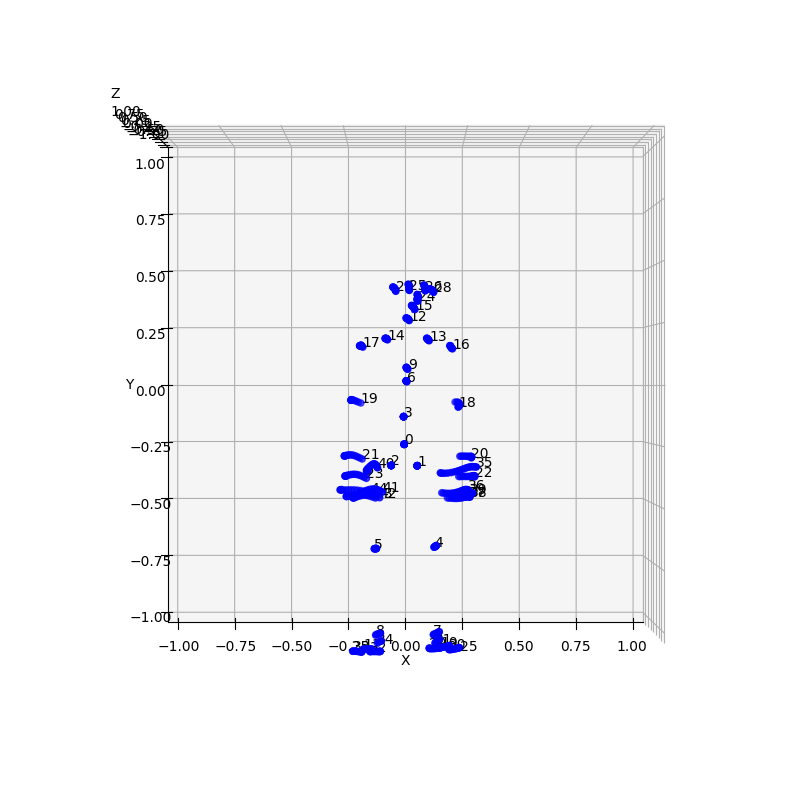

In [41]:
import matplotlib.pyplot as plt
c_joint = c_joint.detach().cpu().numpy()
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(azim=-90, elev=90)

for i in range(16):
    joints = c_joint[i]    # [J, 3]
    J = joints.shape[0]

    x, y, z = joints[:, 0], joints[:, 1], joints[:, 2]

    ax1.scatter(x, y, z, c='b')

for j in range(J):
    ax1.text(x[j], y[j], z[j], s=f'{j}')

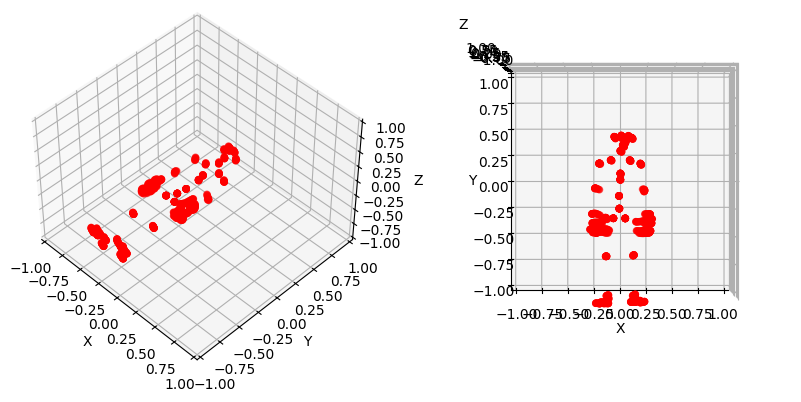

In [20]:
traj_vis_different_view(c_joint)